In [1]:
import torch
import math
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Grayscale
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
# set device to cuda if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
transform_to_tensor = ToTensor()
grayscaler = Grayscale()

def input_transform(img):
    img = grayscaler(img)
    return transform_to_tensor(img)

train_dataset = ImageFolder(root='./FER-2013/train/', transform=input_transform)
val_dataset = ImageFolder(root='./FER-2013/val/', transform=input_transform)
test_dataset = ImageFolder(root='./FER-2013/test/', transform=input_transform)

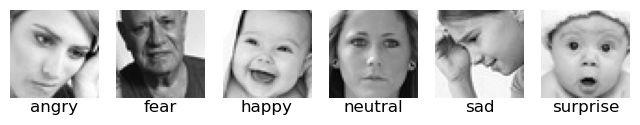

In [4]:
label_map = {
    0: 'angry',
    1: 'fear',
    2: 'happy',
    3: 'neutral',
    4: 'sad',
    5: 'surprise'
}

sample_dataloader = DataLoader(train_dataset, shuffle=True)
data_iterator = iter(sample_dataloader)
num_labels = len(label_map)

fig = plt.figure(figsize=(8, 6))
for i in range(num_labels):
    while True:
        X, y = next(data_iterator)
        if y == i:
            ax = fig.add_subplot(1, num_labels, i+1)
            ax.set_axis_off()
            img = X.squeeze()
            ax.imshow(img.cpu(), cmap='gray')
            ax.set_title(label_map[i], y=-0.25)
            break

## Perceptron

In [5]:
# define network
class MLPNetwork(nn.Module):
    def __init__(self, num_classes: int):
        self.num_classes = num_classes
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(48*48, num_classes),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [6]:
# create an instance of the model defined above
model = MLPNetwork(num_classes=num_labels).to(device)
model.train()

MLPNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=6, bias=True)
    (1): Sigmoid()
  )
)

In [7]:
# setting hyperparameters
learning_rate = 1e-4
batch_size = 64
epochs = 15

In [8]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
def train_loop(dataloader, model, loss_fn, optimizer, log_prefix=None):
    model.train()
    size = len(dataloader.dataset)
    num_correct = 0
    for batch_num, (X, y) in enumerate(tqdm(dataloader)):
        # forward prop
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        num_correct += (y_pred.argmax(dim=1) == y).sum().item()
        # back prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    accuracy = num_correct / size
    print(f'train_loss: {loss.item()}')
    print(f'Train Accuracy: {np.round(accuracy*100,2)}%')
    return accuracy
    
            
def test_loop(dataloader, model, loss_fn, log_prefix=None):
    model.eval()
    size = len(dataloader.dataset)
    num_correct = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(tqdm(dataloader)):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            num_correct += (y_pred.argmax(dim=1) == y).sum().item()
                        
    accuracy = num_correct / size
    print(f'Test Accuracy: {np.round(accuracy*100, 2)}%')
    return accuracy

In [10]:
train_accs = []
val_accs = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    val_acc = test_loop(val_dataloader, model, loss_fn)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print()

epoch 1 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7611573934555054
Train Accuracy: 25.53%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 25.52%

epoch 2 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7531083822250366
Train Accuracy: 26.28%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 26.51%

epoch 3 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7235279083251953
Train Accuracy: 27.71%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 29.06%

epoch 4 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6720912456512451
Train Accuracy: 28.6%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 29.32%

epoch 5 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6742486953735352
Train Accuracy: 29.76%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 30.36%

epoch 6 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6755441427230835
Train Accuracy: 30.21%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 30.62%

epoch 7 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6629873514175415
Train Accuracy: 30.82%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 30.45%

epoch 8 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7257084846496582
Train Accuracy: 31.36%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 31.27%

epoch 9 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6760131120681763
Train Accuracy: 31.71%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 32.63%

epoch 10 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7261286973953247
Train Accuracy: 31.96%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 32.34%

epoch 11 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7608766555786133
Train Accuracy: 32.33%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 32.6%

epoch 12 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6647701263427734
Train Accuracy: 32.43%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.25%

epoch 13 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6609781980514526
Train Accuracy: 32.45%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 32.68%

epoch 14 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6892354488372803
Train Accuracy: 32.75%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.14%

epoch 15 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6518880128860474
Train Accuracy: 33.01%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 32.6%



In [6]:
# evaluating model

def evaluation_loop(dataloader, model):
    model.eval()
    y_predicted = []
    y_actual = []
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            X = X.to(torch.float32).to(device)
            y = y.to(device)
            y_pred = model(X)
            y_actual += [z.cpu().item() for z in y]
            y_predicted += [z.cpu().item() for z in y_pred.argmax(dim=1)]
            
    return y_actual, y_predicted

In [12]:
y_actual, y_predicted = evaluation_loop(test_dataloader, model)

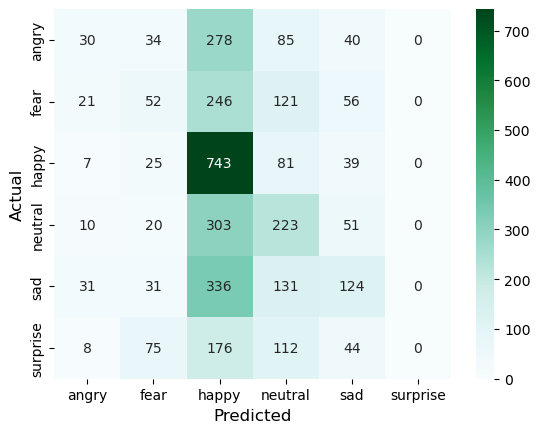

In [13]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = list(label_map.values())
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

## Adding Hidden Layers

In [14]:
# define network
class HiddenNetwork(nn.Module):
    def __init__(self, num_classes: int):
        self.num_classes = num_classes
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(48*48, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [15]:
# create an instance of the model defined above
model2 = MLPNetwork(num_classes=num_labels).to(device)
model2.train()

MLPNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2304, out_features=6, bias=True)
    (1): Sigmoid()
  )
)

In [16]:
# setting hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 15

In [17]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
train_accs = []
val_accs = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_acc = train_loop(train_dataloader, model2, loss_fn, optimizer)
    val_acc = test_loop(val_dataloader, model2, loss_fn)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print()

epoch 1 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.709072470664978
Train Accuracy: 25.54%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 27.82%

epoch 2 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.782249093055725
Train Accuracy: 30.3%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 32.17%

epoch 3 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6692383289337158
Train Accuracy: 31.79%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.53%

epoch 4 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7307347059249878
Train Accuracy: 32.64%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 30.73%

epoch 5 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7221243381500244
Train Accuracy: 32.79%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.5%

epoch 6 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6908706426620483
Train Accuracy: 33.06%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 32.91%

epoch 7 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6901984214782715
Train Accuracy: 33.36%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 31.72%

epoch 8 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6717829704284668
Train Accuracy: 33.55%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.05%

epoch 9 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7831852436065674
Train Accuracy: 33.58%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 34.13%

epoch 10 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6600737571716309
Train Accuracy: 33.85%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.25%

epoch 11 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.674307942390442
Train Accuracy: 33.96%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.31%

epoch 12 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.5949351787567139
Train Accuracy: 33.92%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.19%

epoch 13 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6742076873779297
Train Accuracy: 34.09%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.05%

epoch 14 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.655184268951416
Train Accuracy: 34.31%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.5%

epoch 15 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.674091100692749
Train Accuracy: 34.69%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 33.14%



In [20]:
y_actual, y_predicted = evaluation_loop(test_dataloader, model2)

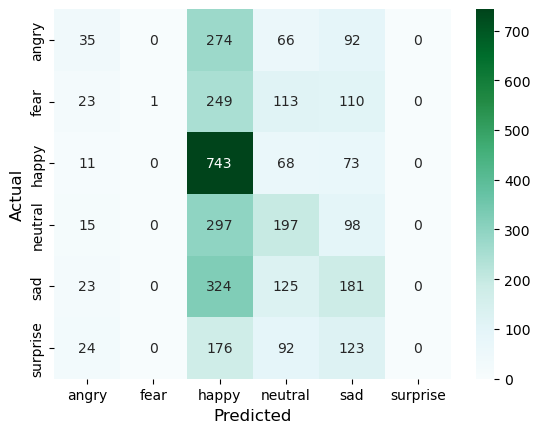

In [21]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = list(label_map.values())
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

## CNN

In [22]:
# define network
class CNN1(nn.Module):
    def __init__(self, num_classes: int):
        self.num_classes = num_classes
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.mlp_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8464, 6)
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.mlp_layers(x)
        return x

In [23]:
# create an instance of the model defined above
cnn1 = CNN1(num_classes=num_labels).to(device)
cnn1.train()

CNN1(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): Conv2d(64, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8464, out_features=6, bias=True)
  )
)

In [24]:
# setting hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 15

In [25]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn1.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [26]:
train_accs = []
val_accs = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_acc = train_loop(train_dataloader, cnn1, loss_fn, optimizer)
    val_acc = test_loop(val_dataloader, cnn1, loss_fn)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print()

epoch 1 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.6706775426864624
Train Accuracy: 26.76%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 35.12%

epoch 2 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.4898444414138794
Train Accuracy: 38.8%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 41.4%

epoch 3 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.5003143548965454
Train Accuracy: 43.36%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 44.48%

epoch 4 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.204567313194275
Train Accuracy: 45.94%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 44.71%

epoch 5 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.3032360076904297
Train Accuracy: 47.14%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 45.64%

epoch 6 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.3658514022827148
Train Accuracy: 49.04%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 47.14%

epoch 7 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.0956720113754272
Train Accuracy: 50.76%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 48.1%

epoch 8 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.376606822013855
Train Accuracy: 52.16%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 47.4%

epoch 9 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.487262487411499
Train Accuracy: 53.51%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 48.25%

epoch 10 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.2659333944320679
Train Accuracy: 55.11%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 49.38%

epoch 11 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.0179822444915771
Train Accuracy: 57.49%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 49.92%

epoch 12 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 0.9919420480728149
Train Accuracy: 59.75%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 49.94%

epoch 13 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.1888948678970337
Train Accuracy: 62.26%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 49.52%

epoch 14 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.2108737230300903
Train Accuracy: 64.39%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 51.05%

epoch 15 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 0.9691223502159119
Train Accuracy: 66.73%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 49.55%



In [27]:
y_actual, y_predicted = evaluation_loop(test_dataloader, cnn1)

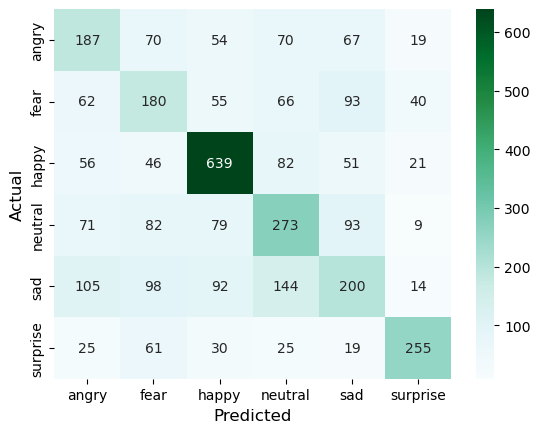

In [28]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = list(label_map.values())
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

In [29]:
# define network
class CNN2(nn.Module):
    def __init__(self, num_classes: int):
        self.num_classes = num_classes
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Conv2d(256, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.mlp_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(33856, 1024),
            nn.ReLU(),
            nn.Linear(1024, 6),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.mlp_layers(x)
        return x

In [30]:
# create an instance of the model defined above
cnn2 = CNN2(num_classes=num_labels).to(device)
cnn2.train()

CNN2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (3): ReLU()
    (4): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (mlp_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=33856, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6, bias=True)
    (4): ReLU()
  )
)

In [31]:
# setting hyperparameters
learning_rate = 1e-3
batch_size = 64
epochs = 15

In [32]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [33]:
train_accs = []
val_accs = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_acc = train_loop(train_dataloader, cnn2, loss_fn, optimizer)
    val_acc = test_loop(val_dataloader, cnn2, loss_fn)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print()

epoch 1 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7928946018218994
Train Accuracy: 17.02%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 2 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7919431924819946
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 3 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7874022722244263
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 4 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7908486127853394
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 5 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.789797067642212
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 6 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7907285690307617
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 7 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.792381763458252
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 8 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7919341325759888
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 9 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7899571657180786
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 10 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.795011281967163
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 11 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7907823324203491
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 12 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.791383981704712
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 13 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7925037145614624
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 14 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.790586233139038
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%

epoch 15 ==================================================


  0%|          | 0/442 [00:00<?, ?it/s]

train_loss: 1.7906055450439453
Train Accuracy: 17.08%


  0%|          | 0/56 [00:00<?, ?it/s]

Test Accuracy: 16.81%



In [34]:
y_actual, y_predicted = evaluation_loop(test_dataloader, cnn2)

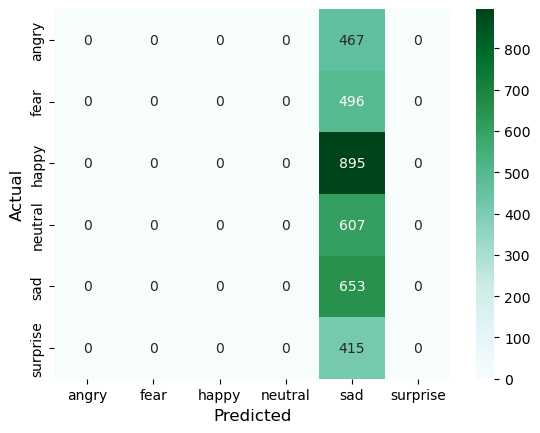

In [35]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = list(label_map.values())
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);

In [7]:
# define network
class CNN4(nn.Module):
    def __init__(self, num_classes: int):
        self.num_classes = num_classes
        super().__init__()
        self.flatten = nn.Flatten()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.4),
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.4),
            nn.Conv2d(256, 64, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(0.4),
            nn.Conv2d(64, 16, kernel_size=3, stride=1, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.mlp_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 6),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.mlp_layers(x)
        return x

In [8]:
# create an instance of the model defined above
cnn4 = CNN4(num_classes=num_labels).to(device)
cnn4.train()

CNN4(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (cnn_layers): Sequential(
    (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.4, inplace=False)
    (5): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.4, inplace=False)
    (10): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout(p=0.4, inplace=False)
    (15

In [ ]:
# setting hyperparameters
learning_rate = 1e-4
batch_size = 64
epochs = 25

In [ ]:
# initialize the loss function and choose an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn4.parameters(), lr=learning_rate)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_accs = []
val_accs = []

for i in range(1, epochs+1):
    print(f'epoch {i}', '='*50)
    train_acc = train_loop(train_dataloader, cnn4, loss_fn, optimizer)
    val_acc = test_loop(val_dataloader, cnn4, loss_fn)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    print()

In [ ]:
y_actual, y_predicted = evaluation_loop(test_dataloader, cnn4)

In [ ]:
# confusion matrix
confmat = confusion_matrix(y_actual, y_predicted)
class_names = list(label_map.values())
sns.heatmap(confmat, xticklabels=class_names, yticklabels=class_names, cmap='BuGn', annot=True, fmt='d')
plt.xlabel('Predicted', size=12)
plt.ylabel('Actual', size=12);